## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [141]:
X.isna().mean()

alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         0.0
dtype: float64

то есть пропущенных значений в датасете нет

In [142]:
X.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

все признаки представлены числовыми значениями, категориальных нет

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [143]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [144]:
np.random.seed(222)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [146]:
# оставляем те признаки, по которым надо обучить
features = ['alcohol', 'magnesium']
X_train, X_test = X_train[features], X_test[features]

In [147]:
# масштабируем признаки
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [148]:
n_neighbors = [1, 3, 5, 10, 15, 25]

In [149]:
from tabulate import tabulate

In [150]:
# список строчек будущего датафрейма с инфой о доле верных ответов
rows = []
headers = ['NN', 'Train', 'Test']

clfs = []

for n in n_neighbors:
  # создаем и обучаем модель для заданного колва соседей
  knn = KNeighborsClassifier(n_neighbors=n, p=2)
  knn.fit(X_train_norm, y_train)
  clfs.append(knn)

  # считаем долю верных ответов на трейне и на тесте
  train_score = knn.score(X_train_norm, y_train)
  test_score = knn.score(X_test_norm, y_test)

  # добавляем строчку с инфой для этого числа соседей
  rows.append([n, train_score, test_score])

# выводим табличку с информацией о доле верных ответов
print(tabulate(rows, headers=headers))

  NN     Train      Test
----  --------  --------
   1  1         0.666667
   3  0.806452  0.777778
   5  0.75      0.722222
  10  0.733871  0.777778
  15  0.733871  0.796296
  25  0.669355  0.796296


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [151]:
# !pip install mlxtend==0.19.00

had to specify the version in order to get rid of an error
https://github.com/rasbt/mlxtend/issues/735

In [152]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

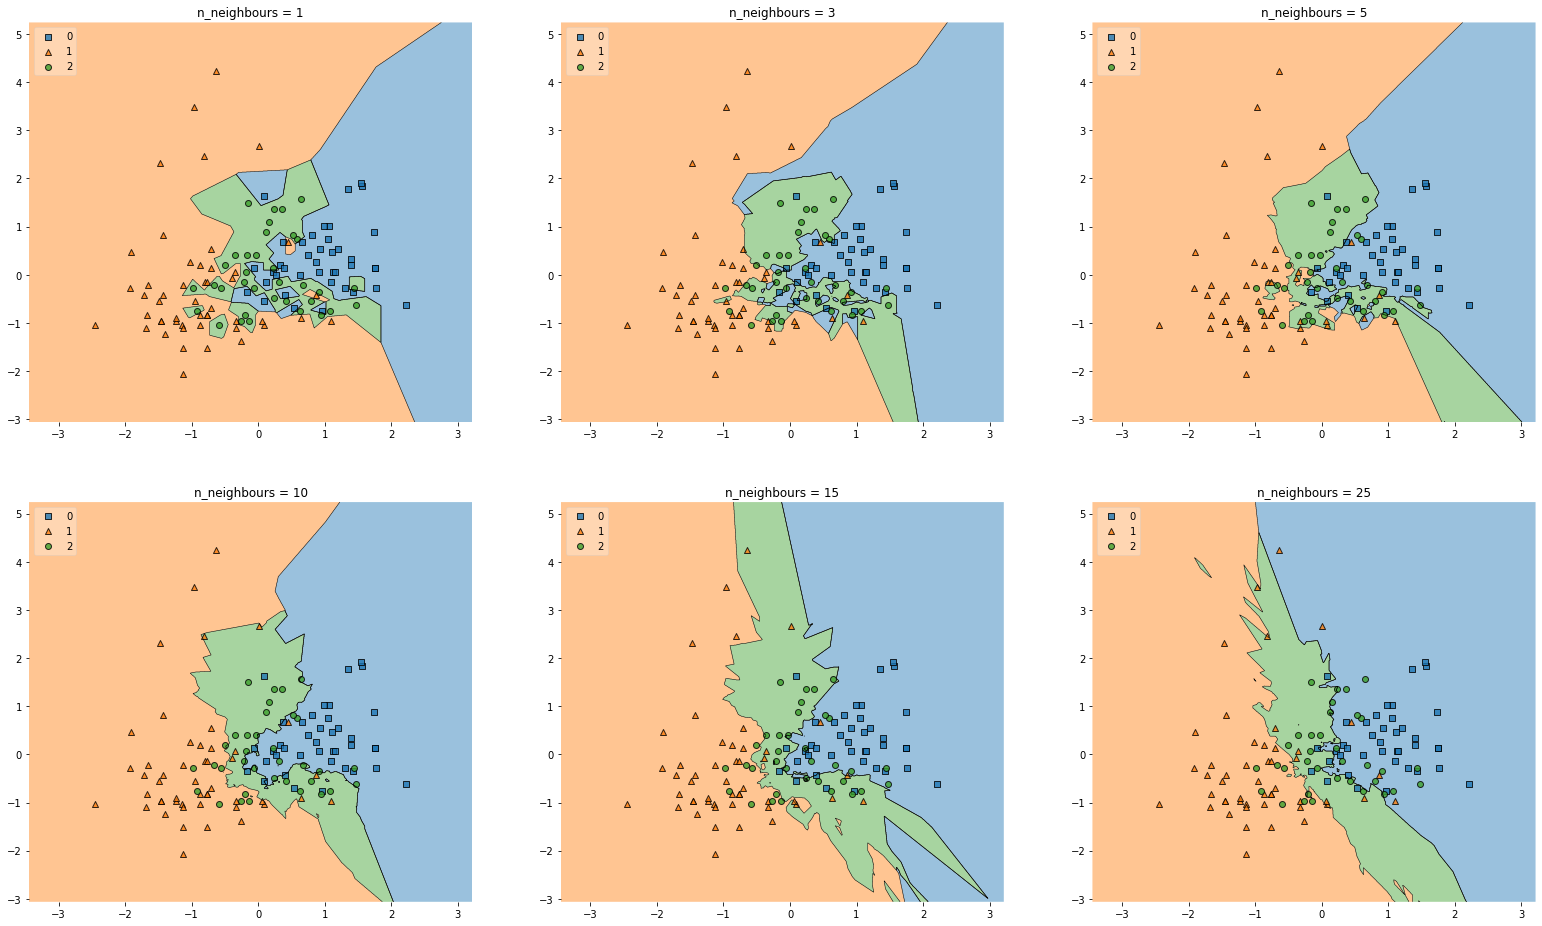

In [153]:
gs = gridspec.GridSpec(3, 3)

fig = plt.figure(figsize=(27, 25))

labels = [f'n_neighbours = {n}' for n in n_neighbors]
for clf, lab, grd in zip(clfs,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
  
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_norm, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

мне кажется, что оптимальное число соседей - 10. несмотря на то что при 15 соседях модель имеет лучшие показатели на тестовой выборке, на решаемой поверхности видно, что именно при 10 соседях нет никаких маленьких островков одного класса внутри другого, границы между категориями выглядят естественно.


можем проверить с помощью грида, какой гиперпараметр будет лучший

In [154]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': n_neighbors}
grid = GridSearchCV(knn, parameters, cv=5)
grid.fit(X_train_norm, y_train)
grid.best_params_

{'n_neighbors': 10}

🤸

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

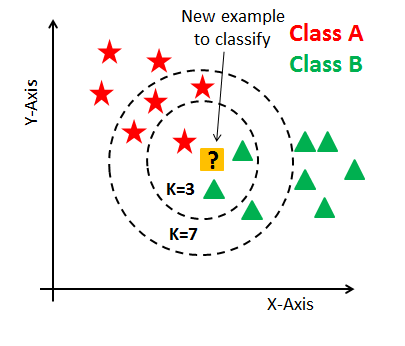

In [155]:
import numpy as np
from collections import Counter 

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
      self.X_train = X
      self.y_train = y
    
    def predict(self, X): 
      predicted = [] # сюда будем складывать классы для каждого нового объекта

      for obj in X:
        # список k объектов, ближайших к новому
        nearest = sorted(self.X_train, key=lambda x: 
                         np.linalg.norm(abs(obj - x)))[:self.k]

        indices = []
        for near in nearest:
          # необходимо найти индексы каждого из ближайших объектов
          idx = np.where((self.X_train == tuple(near)).all(axis=1))[0][0]
          indices.append(idx)

        # теперь по этим индексам мы можем узнать категории всех ближайших объектов
        cats = np.take(self.y_train, indices)

        # ищем самую частую категори.
        cnt = Counter(cats)
        cat_pred = cnt.most_common(1)[0][0]
        predicted.append(cat_pred)

      return np.array(predicted)

In [156]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [157]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

ура! хочется верить, что я делала не самым неоптимальным способом

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [158]:
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2021/homeworks/hw04-knn_linreg/data/diamonds.csv'
data = pd.read_csv(url)
data.head(8)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [159]:
data.isna().mean()

Unnamed: 0    0.0
carat         0.0
cut           0.0
color         0.0
clarity       0.0
depth         0.0
table         0.0
price         0.0
x             0.0
y             0.0
z             0.0
dtype: float64

пропущенных значений нет

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

да, столбик с индексами под названием 'Unnamed: 0' бесполезен

In [160]:
data.drop('Unnamed: 0', axis=1, inplace=True)

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [161]:
data.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


сильная корреляция с целевой переменной 'price' наблюдается у признака 'carat' (0.92), высокая - у признаков 'x' (0.88), 'y' (0.87) и 'z' (0.86)

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [162]:
data_dum = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first=True)
data_dum.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [163]:
# сохраним целевую переменную отдельно
X = data_dum.drop('price', axis=1)
y = data_dum['price'] 

In [164]:
np.random.seed(222)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [165]:
num_feats = ['carat', 'depth', 'table', 'x', 'y', 'z']

In [166]:
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train[num_feats])
X_test_norm = normalizer.transform(X_test[num_feats])

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [168]:
reg = LinearRegression()
reg.fit(X_train_norm, y_train)

LinearRegression()

In [169]:
y_pred_train = reg.predict(X_train_norm)
train_score = reg.score(X_train_norm, y_train)
train_mse = mse(y_pred_train, y_train)
print(f'r2 score on train: {train_score}, mse on train: {train_mse}')

r2 score on train: 0.8583709900646275, mse on train: 2253603.727003835


In [170]:
y_pred_test = reg.predict(X_test_norm)
test_score = reg.score(X_test_norm, y_test)
test_mse = mse(y_pred_test, y_test)
print(f'r2 score on test: {test_score}, mse on test: {test_mse}')

r2 score on test: 0.8611085354782838, mse on test: 2211578.0094714533


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [171]:
reg.coef_

array([ 5008.75031456,  -286.88380581,  -238.82867285, -1369.16387047,
          41.11911937,    13.52358311])

сильно завышены коэффициенты у признаков 'carat' и 'х' (5009 и -1369 соответственно)

у 'depth' и 'table' коэффициенты по модулю не такие большие, как у выше упомянутых признаков, но по сравнению с 'y' и 'z' все же тоже немаленькие (-287 и -239 соответственно).

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [172]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [173]:
alpha = 10

In [174]:
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_norm, y_train)

lasso.coef_

array([4571.29444176, -248.03208879, -223.81320309, -881.98090078,
         -0.        ,   -0.        ])

In [175]:
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_norm, y_train)

ridge.coef_


array([ 4973.59179863,  -284.27905597,  -238.62561332, -1326.05427944,
          37.76066361,     8.10826801])

lasso-регрессия сильнее уменьшила коэффициенты, чем ridge, даже занулив последние. 

на самом деле, не очень понимаю, на чем основываться, делая вывод о том, насколько сильно проблема мультиколлинеарности изначально проявлялась. наверное, достаточно сильно, если у 2 из 6 признаков коэффициенты занулились, а у одного ('x') модуль уменьшился почти в 2 раза (1369 -> 882)

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [176]:
from matplotlib import pyplot as plt

In [177]:
alphas = [0.1, 1, 10, 100, 200]

In [178]:
lasso_coef_norm, ridge_coef_norm = [], []

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_train_norm, y_train)
  lasso_coef_norm.append(np.linalg.norm(lasso.coef_))

  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train_norm, y_train)
  ridge_coef_norm.append(np.linalg.norm(ridge.coef_))

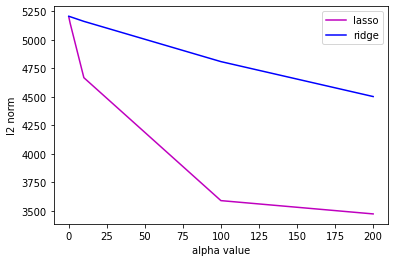

In [179]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha value')
ax.set_ylabel('l2 norm')

plt.plot(alphas, lasso_coef_norm, label='lasso', color='m')
plt.plot(alphas, ridge_coef_norm, label='ridge', color='b')
ax.legend()

plt.show()

lasso агрессивнее - если ridge только уменьшает коэффициенты неинформативных признаков, максимум приближая их к нулю, то lasso такие может просто занулить. и именно по этой причине ее можно использовать для отбора признаков.

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [180]:
from sklearn.linear_model import LassoCV

In [181]:
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=2000)
lasso_cv.fit(X_train_norm, y_train)
lasso_cv.alphas_ = alphas

mean_mses = np.mean(lasso_cv.mse_path_, axis=0)

min_mse = np.min(mean_mses)
final_alpha = alphas[np.where(mean_mses == min_mse)[0][0]]

print(f'minimal mse ({min_mse}) is when alpha equals {final_alpha}')

minimal mse (2242108.4759746594) is when alpha equals 1


указала макс. кол-во итераций чтоб решить ошибку ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. (https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge)

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [182]:
lasso = Lasso(alpha=final_alpha)
lasso.fit(X_train_norm, y_train)

lasso.coef_

array([ 4966.03859772,  -281.79468037,  -237.60144925, -1289.07277479,
          15.69582911,    -0.        ])

самыми информативными оказались признаки 'carat' и 'x', то есть вес бриллианта в каратах и его длина в мм соответственно.

наименее информативные - 'y' и 'z', т.е. ширина и глубина в мм.

-


каратность - главный определяющий цену признак бриллианта. '[стоимость бриллианта имеет тенденцию резко возрастать с увеличением массы бриллианта](https://uvelir.info/articles/chto_oznachayut_harakteristiki_brillianta/)'. '[чем выше вес в каратах, тем выше цена и эта зависимость геометрическая](https://isradiamond.ru/cema-brillianta/)'. логично: больше вес бриллианта, больше его размер, больше цена.

длину бриллианта можно соотнести с его формой. при этом '[со скидкой оцениваются бриллианты, имеющие форму багет или трапеция. Но классической формой бриллианта, служащей эталоном цены, считается круглая форма](https://ru.wikipedia.org/wiki/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%B1%D1%80%D0%B8%D0%BB%D0%BB%D0%B8%D0%B0%D0%BD%D1%82%D0%BE%D0%B2)'. коэффициент данного признака является отрицательным, все логично: чем он длиннее, тем, соответственно, вытянутее он становится и отдаляется от круглой формы. 

кажется, что вышесказанное противоречит маловажности признаков ширины и глубины, но нет. эти признаки имеют значение, но не в чистом виде - более определяющим оказывается их соотношение с диаметром: '[соотношение ширины и глубины бриллианта создает наибольший эффект преломления светового луча, как свет проходит в бриллиант, преломляется в нем и выходит из бриллианта через корону](https://isradiamond.ru/cema-brillianta/)' - это как раз признаки 'depth' и 'table', коэффициенты которых не такие маленькие, как у 'y' и 'z'.


**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [183]:
y_pred_lasso = lasso_cv.predict(X_test_norm)
test_mse_lasso = mse(y_pred_lasso, y_test)

res = {'lasso with cv': test_mse_lasso, 'linear regression': test_mse}
print(f'{min(res, key=res.get)} model has lower mse: {res[min(res, key=res.get)]}')

linear regression model has lower mse: 2211578.0094714533


обычная линейная регрессия на получившихся выборках сработала лучше, чем лассо. мои версии:

1) может, проблема мультиколлинеарности все-таки не была такой серьезной и не было необходимости обнулять коэффициенты признаков 'y' и 'z', поэтому линрег с оригинальными коэффициентами подошла лучше

2) просто так сложилась выборка. но если поиграть с рандомом, тогда лучше сработает лассо. даже не знаю, от нее ожидаешь более качественный результат, тк корреляция между признаками была и была сильная, поэтому проблема же все-таки есть и использование лассо должно быть обоснованно?